In [20]:
from sys import exit, exc_info, argv
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import mlab
from matplotlib import gridspec
import pandas as pd

!pip3 install git+https://github.com/slremy/netsapi --user --upgrade

from netsapi.challenge import *

from contextlib import contextmanager
import sys, os
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
import statistics
from IPython.display import clear_output
import copy


  Cloning https://github.com/slremy/netsapi to c:\users\admin\appdata\local\temp\pip-req-build-b00guu7f


  Running command git clone -q https://github.com/slremy/netsapi 'C:\Users\ADMIN\AppData\Local\Temp\pip-req-build-b00guu7f'
    ERROR: Complete output from command python setup.py egg_info:
    ERROR: Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "d:\devapps\python3.6.5\lib\tokenize.py", line 452, in open
        buffer = _builtin_open(filename, 'rb')
    FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ADMIN\\AppData\\Local\\Temp\\pip-req-build-b00guu7f\\setup.py'
    ----------------------------------------
ERROR: Command "python setup.py egg_info" failed with error code 1 in C:\Users\ADMIN\AppData\Local\Temp\pip-req-build-b00guu7f\
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [51]:
#### TRICK HERE ####
# SEARCH FOR MAX REWARD OF YEAR 1 THEN APPLY GA ON THE REMAINING YEARS
# Search max year 1 
def actionSpace(resolution):
    x,y = np.meshgrid(np.arange(0,1.1,resolution), np.arange(0,1.1,resolution))
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    return xy.round(2).tolist()

def exploitSpace(action,resolution):
    cactionspace = []
    final = []
    for i in [resolution,0,-resolution]:
        for j in [resolution,0,-resolution]:
            cactionspace.append([action[0]+j,action[1]+i])
    for a in cactionspace:
        if(a not in memory and a[0]<=1 and a[0]>=0 and a[1]<=1 and a[1]>=0):
            final.append(a)
    print("final: ", final)
    return final

action_resolution_year1 = 0.3
actionyear1 = actionSpace(action_resolution_year1)
actionspaceyear1 = range(len(actionyear1)-1)
memory = []
action_resolution = 0.1
maxactionyear1 = []
rewardmaxyear1 = -9999
count = 20

# ChallengeSeqDecEnvironment = environment 1 (Old Environment)
# ChallengeProveEnvironment = environment 2 (New Environment)

env = ChallengeProveEnvironment()
# env = ChallengeSeqDecEnvironment()

for a in actionyear1:
            
    tempa = a
    count-=1
    env.reset()
    _,reward,_,_ = env.evaluateAction(tempa);
    memory.append(tempa)
    if(reward > rewardmaxyear1):
        rewardmaxyear1 = reward
        maxactionyear1 = tempa

spaceExploit = exploitSpace(maxactionyear1, action_resolution)

while(count>0):
    env.reset()
    nextaction = []
    direct = 0
    if(direct == 1):
        actionchoice = nextaction
    else:
        actionchoice = random.choice(spaceExploit)
    if(actionchoice not in memory):
        env.reset()
        _,reward,_,_ = env.evaluateAction(actionchoice)
        count-=1
        memory.append(actionchoice)
        direction = [actionchoice[0] - maxactionyear1[0],actionchoice[1] - maxactionyear1[1]]
        if(reward > rewardmaxyear1):
            rewardmaxyear1 = reward
            maxactionyear1 = actionchoice
            nextaction = [actionchoice[0] + direction[0],actionchoice[1] + direction[1]]
            direct =1
            if(nextaction[0] >1 or nextaction[0] <0 or nextaction[1] >1 or nextaction[1] <0):
                nextaction = [actionchoice[0] - direction[0],actionchoice[1] - direction[1]]
                spaceExploit = exploitSpace(nextaction, action_resolution)
                direct = 0


105  Evaluations Remaining
104  Evaluations Remaining
103  Evaluations Remaining
102  Evaluations Remaining
101  Evaluations Remaining
100  Evaluations Remaining
99  Evaluations Remaining
98  Evaluations Remaining
97  Evaluations Remaining
96  Evaluations Remaining
95  Evaluations Remaining
94  Evaluations Remaining
93  Evaluations Remaining
92  Evaluations Remaining
91  Evaluations Remaining
90  Evaluations Remaining
final:  [[0.4, 1.0], [0.3, 1.0], [0.19999999999999998, 1.0], [0.4, 0.9], [0.19999999999999998, 0.9], [0.4, 0.8], [0.3, 0.8], [0.19999999999999998, 0.8]]
89  Evaluations Remaining
88  Evaluations Remaining
87  Evaluations Remaining
final:  [[0.4, 1.0], [0.19999999999999998, 1.0], [0.19999999999999998, 0.9], [0.4, 0.8], [0.19999999999999998, 0.8]]
86  Evaluations Remaining


In [52]:
class CustomAgent:
    def __init__(self, environment=1, episode_number=1):
        if environment == 1:
            self.environment = ChallengeSeqDecEnvironment()
        else:
            self.environment = ChallengeProveEnvironment()
        self.episode_number = episode_number

        self.run = []
        self.scores = []
        self.policies = []
        self.seed = {'1': [0.0, 0.8], '2': [1.0, 0.0], '3': [0.1, 0.8], '4': [1.0, 0.0], '5': [0.2, 0.8]}
        
    def evaluateAPolicy(self, individualPolicy):
        self.environment.reset()
        rewards = self.environment.evaluatePolicy(individualPolicy)
        print("Policy", individualPolicy, "yields reward", rewards)
        
    def my_generate(self, randomGeneration):
        try:
            self.environment.reset()
            # number of 1st policies
            n1stEp = 20
            # number of new policies to be created
            nNew = 180
#             # Generate randomly 20 policies - 1st generation
#             policies = []
#             for i in range(n1stEp):
#                 policy = {}
#                 for j in range(5): # 5 years
#                     policy[str(j + 1)] = [random.random(), random.random()]
#                 policies.append(policy)    

            # 26.06.19 Generate 1st gen based on seed
            policies = []
            for i in range(n1stEp):
                policy = {}
                for j in range(5):
                    feature1 = random.random() + self.seed[str(j + 1)][0]
                    feature2 = random.random() + self.seed[str(j + 1)][1]
                    if feature1 < 0.0:
                        feature1 = 0.0
                    elif feature1 > 1.0:
                        feature1 = 1.0
                    if feature2 < 0.0:
                        feature2 = 0.0
                    elif feature2 > 1.0:
                        feature1 = 1.0    
                    policy[str(j + 1)] = [feature1, feature2]

            rewards = self.environment.evaluatePolicy(policies)
#             print("1st gen policies length: ", len(policies))
#             print("1st gen rewards length: ", len(rewards))

            for episode in range(nNew):
#                 print("Episode ", episode)
                newPolicy, newReward = self.roulette_wheel_selection(policies, rewards)
                policies.append(newPolicy)
                rewards.append(newReward)            
        except (KeyboardInterrupt, SystemExit, ValueError):
            print(exc_info())
        return policies[np.argmax(rewards)], rewards[np.argmax(rewards)]

    def roulette_wheel_selection(self, current_policies, current_rewards, noise1=0.0, noise2=0.0):
        maxR = np.max(current_rewards)
        minR = np.min(current_rewards)
        fitness = []
        for reward in current_rewards:
            normalized = (reward - minR) / (maxR - minR)
            fitness.append(normalized * (-1.0))
        
        sumFitness = np.sum(fitness)
        p = []
        for f in fitness:
            p.append(f / sumFitness)
            
        # sort policies, rewards, fitness, probabilities based on probability
        for i in range(len(p) - 1):
            for j in range(i + 1, len(p)):
                if p[i] > p[j]:
                    # swap prob
                    temp = p[i]
                    p[i] = p[j]
                    p[j] = temp
                    
                    # swap policies
                    temp = current_policies[i]
                    current_policies[i] = current_policies[j]
                    current_policies[j] = temp
                    
                    # swap rewards
                    temp= current_rewards[i]
                    current_rewards[i] = current_rewards[j]
                    current_rewards[j] = temp
                    
                    # swap fitness
                    temp = fitness[i]
                    fitness[i] = fitness[j]
                    fitness[j] = temp
                    
        # choose 2 policies from the set
        chosenPolicies = []
        chosenIndex = -1
#         for chosenI in range(2):
        while len(chosenPolicies) < 2:
            randomSelection = np.random.uniform(p[0], p[len(p)-1])
            for index, pi in enumerate(p):
                if randomSelection < pi and chosenIndex != index:
                    chosenPolicies.append(current_policies[index])
                    chosenIndex = index
                    break
        # Create new policy by mixing the 2 chosen policies
        newPolicy = {}
        for i in range(0, 5):    # 5 years (states)
            chosen = 0
            if np.random.uniform(0, 1) > 0.5:
                chosen = 1
            newPolicy[str(i + 1)] = chosenPolicies[chosen][str(i + 1)]
            
            # then add noise into them
            newPolicy[str(i + 1)][0] += noise1
            newPolicy[str(i + 1)][1] += noise2
            
            if newPolicy[str(i + 1)][0] > 1.0:
                newPolicy[str(i + 1)][0] = 1.0
            if newPolicy[str(i + 1)][0] < 0.0:
                newPolicy[str(i + 1)][0] = 0.0
            if newPolicy[str(i + 1)][1] > 1.0:
                newPolicy[str(i + 1)][1] = 1.0
            if newPolicy[str(i + 1)][1] < 0.0:
                newPolicy[str(i + 1)][1] = 0.0
        newPolicy['1'] = copy.deepcopy(maxactionyear1)    #### TRICK HERE ####
        
        # new reward
        newReward = self.environment.evaluatePolicy(newPolicy)
        return newPolicy, newReward
        
    def scoringFunction(self):
        scores = []
        for ii in range(1):
#             print("Run #", ii)
            self.environment.reset()
            finalresult, reward = self.my_generate()
            self.policies.append(finalresult)
            self.scores.append(reward)
            self.run.append(ii)
#         print("Length: ", len(self.scores))
        return np.mean(self.scores)/np.std(self.scores)
 
        
    def create_submissions(self, filename = 'my_submission.csv'):
        labels = ['run', 'reward', 'policy']
        rewards = np.array(self.scores)
        data = { 'run': self.run, 
                 'rewards': rewards,
                 'policy': self.policies,
               }
        submission_file = pd.DataFrame(data)
        submission_file.to_csv(filename, index=False)

In [53]:
numOfRun = 10 ########### NUM OF RUNS ############
rewardsRun = []
evolutionReward = []
useEnvironment = 2
# Generate randomly 5 policies - 1st generation
noises = np.linspace(0.05, 0.95, 21)
for run in range(numOfRun):
    print("=== START RUN #", run + 1, " / ", numOfRun, " ON ENVIRONMENT ", useEnvironment, " ===")
    entityCnt = 0
    firstGeneration = []
    run = []
    evolutionReward = []
    agent = CustomAgent(environment=useEnvironment)
    # each policy costs 5 evaluations, so firstPopulation * 5 evaluations, 105 = 21 run
    numOfFirstPopulation = 4       # change here
    for i in range(numOfFirstPopulation):
        policy = {}
        run.append(i)
        for j in range(5): # 5 years
            policy[str(j + 1)] = [np.random.uniform(0.0, 1.0), np.random.uniform(0.0, 1.0)]
        policy['1'] = copy.deepcopy(maxactionyear1)   #### TRICK HERE ####
        firstGeneration.append(policy)    
        entityCnt = entityCnt + 1
    
    # 1st gen
    print("1st generation:", firstGeneration)
    firstGenRewards = agent.environment.evaluatePolicy(firstGeneration)
    evolutionReward = firstGenRewards.copy()

    # Generate new 10000 policies based on GA
    numOfExpoitedPopulation = (80 - numOfFirstPopulation * 5) / 5
    for i in range(int(numOfExpoitedPopulation)):
        run.append(i)
        newPolicy, newReward = agent.roulette_wheel_selection(firstGeneration, firstGenRewards, noises[entityCnt], noises[entityCnt])
        firstGeneration.append(newPolicy)
        firstGenRewards.append(newReward)
        evolutionReward.append(newReward)
        entityCnt = entityCnt + 1

    # Write file
    labels = ['run', 'reward', 'policy']
    data = { 'run': run, 
             'rewards': firstGenRewards,
             'policy': firstGeneration,
           }
    # submission_file = pd.DataFrame(data)
    # submission_file.to_csv("result.csv", index=False)
    print("Max rewards: ", np.max(data['rewards']))

    rewardsRun.append(np.max(data['rewards']))

=== START RUN # 1  /  10  ON ENVIRONMENT  2  ===
1st generation: [{'1': [0.19999999999999998, 0.9], '2': [0.935223049996954, 0.9621210364858436], '3': [0.609489018187597, 0.2539222594620282], '4': [0.9265680530727578, 0.11802032084173186], '5': [0.8509572757476047, 0.4702599224427454]}, {'1': [0.19999999999999998, 0.9], '2': [0.8800989385475777, 0.45740541635119847], '3': [0.7729827665533537, 0.07559780967726892], '4': [0.31583677137171984, 0.669430717491807], '5': [0.5836236605060183, 0.20689986839711838]}, {'1': [0.19999999999999998, 0.9], '2': [0.05493321148774588, 0.9865114406469137], '3': [0.1710086401345945, 0.6539163302195657], '4': [0.6990891997780653, 0.967251077370552], '5': [0.8351146621140778, 0.8056362747956396]}, {'1': [0.19999999999999998, 0.9], '2': [0.8258938020772829, 0.24216172481413467], '3': [0.4096158688158078, 0.8348230976711005], '4': [0.05996088980153791, 0.08795665184745516], '5': [0.16596496875041822, 0.668444362414795]}]
105  Evaluations Remaining
85  Evalua

85  Evaluations Remaining
80  Evaluations Remaining
75  Evaluations Remaining
70  Evaluations Remaining
65  Evaluations Remaining
60  Evaluations Remaining
55  Evaluations Remaining
50  Evaluations Remaining
45  Evaluations Remaining
40  Evaluations Remaining
35  Evaluations Remaining
30  Evaluations Remaining
Max rewards:  343.40199151494704
=== START RUN # 8  /  10  ON ENVIRONMENT  2  ===
1st generation: [{'1': [0.19999999999999998, 0.9], '2': [0.4226356791973803, 0.8545158521512757], '3': [0.8069333377964398, 0.6474185291622193], '4': [0.7921084087028929, 0.47493713100191937], '5': [0.2086328175162383, 0.12390111496040801]}, {'1': [0.19999999999999998, 0.9], '2': [0.3069322867775387, 0.8049033716789713], '3': [0.7466409095488511, 0.731742827926638], '4': [0.05320418514304592, 0.4790264480670605], '5': [0.8061989713531929, 0.13585218667295407]}, {'1': [0.19999999999999998, 0.9], '2': [0.09842949355160546, 0.5270529101399931], '3': [0.3029619855843062, 0.959147889610902], '4': [0.5638

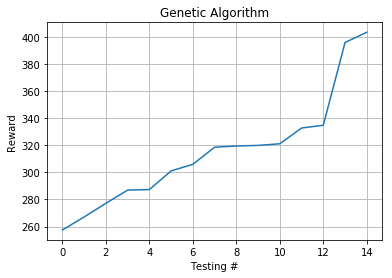

In [54]:
# print("firstGenRewards", firstGenRewards)
# print("evolutionReward", evolutionReward)
fig, ax = plt.subplots()
ax.plot([i for i in range(0, len(firstGenRewards) - 1)], firstGenRewards[:-1])

ax.set(xlabel='Testing #', 
       ylabel='Reward',
       title='Genetic Algorithm')
ax.grid()

fig.savefig("test.png")
plt.show()